In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb
from tqdm import tqdm
import hiplot as hip
from copy import deepcopy
import datetime

In [3]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset, TensorDataset

In [4]:
cwd = os.getcwd()
print(cwd)
# cwd_parent = os.path.abspath(os.path.join(cwd, os.pardir))
cwd_parent = os.path.abspath(os.path.join(cwd, '../../'))
print(cwd_parent)

sys.path.append(cwd_parent)

/opt/data/chemprop_run/git/notebooks/AltModels
/opt/data/chemprop_run/git


In [5]:
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
from deepadr.hyphelperflat import *
from deepadr.model_gnn_ogb import GNN, DeepAdr_SiameseTrf, ExpressionNN
from ogb.graphproppred import Evaluator

In [6]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [7]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [8]:
report_available_cuda_devices()

number of GPUs available: 5
cuda:0, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:1, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:2, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:3, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:4, 

In [9]:
n_gpu = torch.cuda.device_count()
n_gpu

5

In [10]:
device_cpu = get_device(to_gpu=False)
# device_gpu = get_device(True, index=0)

# fdtype = torch.float32

In [11]:
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)
print(sys.version)

torch: 1.9.1
CUDA: 11.1
3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) 
[GCC 9.4.0]


### Preparing dataset 

In [12]:
score = 'total_thresh' #'total_thresh'
score_val = 4

In [13]:
DSdataset_name = f'DrugComb_{score}_{score_val}'

# v_1: GNN
# v_2: Alt Models (Baseline)
data_fname = 'data_v2'

In [14]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
targetdata_dir_exp = create_directory(os.path.join(targetdata_dir, "experiments"))
print(targetdata_dir)

path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
/opt/data/chemprop_run/git/data/processed/DrugComb_total_thresh_4/data_v2


In [15]:
xFlat = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'X_flat.pkl'))
y = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'y.pkl'))
expression = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'expression.pkl'))

In [16]:
xFlatMat = torch.stack([torch.cat(i) for i in list(xFlat.values())])
xFlatMat.shape

torch.Size([25757, 18])

In [17]:
torch.tensor(expression)

tensor([[ 0.1661,  0.2518,  1.3373,  ..., -0.4085,  0.8581,  0.8979],
        [ 0.1661,  0.2518,  1.3373,  ..., -0.4085,  0.8581,  0.8979],
        [ 0.1661,  0.2518,  1.3373,  ..., -0.4085,  0.8581,  0.8979],
        ...,
        [-0.0373, -1.4322,  1.5411,  ..., -1.2711,  1.2013,  0.9537],
        [-0.0373, -1.4322,  1.5411,  ..., -1.2711,  1.2013,  0.9537],
        [-0.0373, -1.4322,  1.5411,  ..., -1.2711,  1.2013,  0.9537]],
       dtype=torch.float64)

In [18]:
x = torch.cat([xFlatMat, torch.tensor(expression)], dim=1)
x.shape

torch.Size([25757, 926])

In [19]:
y

array([0, 0, 0, ..., 0, 1, 1])

In [20]:
x.shape

torch.Size([25757, 926])

In [21]:
y.shape

(25757,)

In [22]:
fold_partitions = get_stratified_partitions(y,
                                            num_folds=5,
                                            valid_set_portion=0.1,
                                            random_state=42)

fold_num: 0
train data
class: 0 norm count: 0.5764128559102675
class: 1 norm count: 0.4235871440897325
validation data
class: 0 norm count: 0.5764192139737991
class: 1 norm count: 0.42358078602620086
test data
class: 0 norm count: 0.5764751552795031
class: 1 norm count: 0.4235248447204969

-------------------------
fold_num: 1
train data
class: 0 norm count: 0.5764128559102675
class: 1 norm count: 0.4235871440897325
validation data
class: 0 norm count: 0.5764192139737991
class: 1 norm count: 0.42358078602620086
test data
class: 0 norm count: 0.5764751552795031
class: 1 norm count: 0.4235248447204969

-------------------------
fold_num: 2
train data
class: 0 norm count: 0.5764356969533567
class: 1 norm count: 0.4235643030466433
validation data
class: 0 norm count: 0.5764192139737991
class: 1 norm count: 0.42358078602620086
test data
class: 0 norm count: 0.5763929334109882
class: 1 norm count: 0.4236070665890118

-------------------------
fold_num: 3
train data
class: 0 norm count: 0.576

In [23]:
print("Number of training graphs: "+ str(len(fold_partitions[0]['train'])))
print("Number of validation graphs: "+ str(len(fold_partitions[0]['validation'])))
print("Number of testing graphs: "+ str(len(fold_partitions[0]['test'])))


Number of training graphs: 18544
Number of validation graphs: 2061
Number of testing graphs: 5152


### Preprocessing

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [25]:
x_np = x.numpy()
y_np = y

In [26]:
pipeline = compose(scaler.fit_transform, np.tanh, scaler.fit_transform)

In [27]:
x_np_norm = pipeline(x_np)

In [28]:
deepsynergy_input_size = x_np_norm.shape[1]
deepsynergy_input_size

926

In [29]:
ids = list(range(len(y)))

In [30]:
dataset = TensorDataset(torch.tensor(x_np_norm),torch.tensor(y), torch.tensor(ids))
dataset

In [31]:
x_np_norm.shape

(25757, 926)

In [32]:
fold_partitions[0]['test']

array([    4,    13,    16, ..., 25731, 25743, 25753])

### Deep Synergy

In [33]:
# training params total_thresh 4
tp = {
    "batch_size" : 300,
    "num_epochs" : 100,
    
    "emb_dim" : 300,
    "gnn_type" : "gatv2",
    "num_layer" : 5,
    "graph_pooling" : "mean", #attention
    
    "input_embed_dim" : None,
    "gene_embed_dim": 1,
    "num_attn_heads" : 2,
    "num_transformer_units" : 1,
    "p_dropout" : 0.3,
#     "nonlin_func" : nn.ReLU(),
    "mlp_embed_factor" : 2,
    "pooling_mode" : 'attn',
    "dist_opt" : 'cosine',

    "base_lr" : 3e-5, #3e-4
    "max_lr_mul": 5,
    "l2_reg" : 1e-5,
    "loss_w" : 1.,
    "margin_v" : 1.,

    "expression_dim" : 64,
    "expression_input_size" : 908,
    "exp_H1" : 8192,
    "exp_H2" : 4096
}

In [34]:
tp['deepsynergy_input_size'] = deepsynergy_input_size
tp['deepsynergy_input_size']

926

In [35]:
def spawn_q_process(q_process):
    print(">>> spawning hyperparam search process")
    q_process.start()
    
def join_q_process(q_process):
    q_process.join()
    print("<<< joined hyperparam search process")
    
def create_q_process(queue, used_dataset, gpu_num, tphp, exp_dir, partition): #
#     fold_gpu_map = {0:gpu_num}
    return mp.Process(target=deepadr.hyphelperflat.run_exp_flat, args=(queue, used_dataset, gpu_num, tphp, exp_dir, partition)) #

def create_q_process_attr(queue, x_np_norm, gpu_num, tphp, exp_dir, partition, labels): #
#     fold_gpu_map = {0:gpu_num}
    return mp.Process(target=deepadr.hyphelperflat.run_attribution, args=(queue, x_np_norm, gpu_num, tphp, exp_dir, partition, labels)) #

In [36]:
# import torch.multiprocessing as mp
# mp.set_start_method("spawn", force=True)

# queue = mp.Queue()
# q_processes = []

# # partition = fold_partitions[0]
# time_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# print("Start: " + time_stamp)

# for q_i in range(min(n_gpu, len(fold_partitions))):
# #     device_gpu = get_device(True, index=q_i)
#     partition = fold_partitions[q_i]
#     exp_dir = create_directory(os.path.join(targetdata_dir_exp, "fold_"+str(q_i)+"_"+time_stamp))
#     create_directory(os.path.join(exp_dir, "predictions"))
#     create_directory(os.path.join(exp_dir, "modelstates"))

# #     tphp = generate_tp_hp(tp, hyperparam_space[q_i], hp_names)
    
#     q_process = create_q_process(queue, dataset, q_i, tp, exp_dir, partition)
#     q_processes.append(q_process)
#     spawn_q_process(q_process)

# spawned_processes = n_gpu
    
# # for q_i in range(len(hyperparam_space)):
# for q_i in range(min(n_gpu, len(fold_partitions))):
#     join_q_process(q_processes[q_i])
#     released_gpu_num = queue.get()
#     print("released_gpu_num:", released_gpu_num)
# #     if(spawned_processes < len(hyperparam_space)):
# # #         device_gpu = get_device(True, index=q_i)
# #         time_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# #         exp_dir = create_directory(os.path.join(targetdata_dir_exp, "exp_"+str(q_i)+"_"+time_stamp))
# #         tphp = generate_tp_hp(tp, hyperparam_space[q_i], hp_names)

# #         q_process = create_q_process(queue, used_dataset, released_gpu_num, tphp, exp_dir, partition)
# #         q_processes.append(q_process)
# #         spawn_q_process(q_process)
# #         spawned_processes = spawned_processes + 1

In [37]:
print("End: " + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

End: 2022-06-24_09-42-52


### Get Predictions

In [38]:
time_stamp = '2022-06-22_16-02-28'

In [39]:
import glob
exp_dirs = glob.glob(targetdata_dir_exp+"/fold_*_"+time_stamp)
len(exp_dirs)

5

In [40]:
best_epoch = 99

In [41]:
print("best epoch:", best_epoch)

l_pred = []

for edir in exp_dirs:
    predictions = pd.read_csv(edir + f"/predictions/epoch_{best_epoch}_predictions_test.csv")
    l_pred.append(predictions)

best epoch: 99


In [42]:
l_pred[0]

,id,true_class,pred_class,prob_score_class0,prob_score_class1
0,10,0.0,1,0.478081,5.219193e-01
1,12,1.0,0,0.868957,1.310435e-01
2,17,0.0,0,1.000000,1.058048e-10
3,28,1.0,1,0.153701,8.462992e-01
4,35,0.0,0,0.986174,1.382562e-02
...,...,...,...,...,...
5146,25737,1.0,1,0.000620,9.993798e-01
5147,25744,1.0,1,0.000002,9.999983e-01
5148,25745,1.0,1,0.003959,9.960411e-01
5149,25747,1.0,1,0.021445,9.785548e-01


In [43]:
df_pred = pd.concat(l_pred, axis=0).astype({"id":int, "true_class":int}).set_index("id")
df_pred

,true_class,pred_class,prob_score_class0,prob_score_class1
id,,,,
10,0,1,0.478081,5.219193e-01
12,1,0,0.868957,1.310435e-01
17,0,0,1.000000,1.058048e-10
28,1,1,0.153701,8.462992e-01
35,0,0,0.986174,1.382562e-02
...,...,...,...,...
25735,0,0,0.948470,5.152988e-02
25741,1,1,0.000873,9.991272e-01
25742,1,1,0.000433,9.995673e-01


In [44]:
df_pred_TP = df_pred[((df_pred.true_class == 0) & (df_pred.pred_class == 0)) |
                     ((df_pred.true_class == 1) & (df_pred.pred_class == 1))]
df_pred_TP

,true_class,pred_class,prob_score_class0,prob_score_class1
id,,,,
17,0,0,1.000000,1.058048e-10
28,1,1,0.153701,8.462992e-01
35,0,0,0.986174,1.382562e-02
36,0,0,0.999167,8.327112e-04
46,1,1,0.000016,9.999836e-01
...,...,...,...,...
25735,0,0,0.948470,5.152988e-02
25741,1,1,0.000873,9.991272e-01
25742,1,1,0.000433,9.995673e-01


In [45]:
df_pred_TP.index.values

array([   17,    28,    35, ..., 25742, 25750, 25752])

In [73]:
df_pred_TP_RI = df_pred_TP.reset_index()

df_pred_TP_zeros = df_pred_TP_RI[df_pred_TP_RI.true_class == 0].index
df_pred_TP_ones = df_pred_TP_RI[df_pred_TP_RI.true_class == 1].index

In [74]:
len(df_pred_TP_zeros) + len(df_pred_TP_ones)

21018

### Run Attributions

In [46]:
# idxs = []

# for fold in fold_partitions.values():
# #     print(fold)
#     idxs.append(fold['test'])
    
# test_idxs = np.concatenate(idxs)
# test_idxs.shape

In [68]:
test_features = np.take(x_np_norm, df_pred_TP.index.values, axis=0)
test_features#.shape

array([[ 4.09203199, -0.16778051, -1.3209781 , ...,  0.13588219,
         0.73121597, -0.67645394],
       [-0.52895289, -0.16778051,  1.0027469 , ...,  0.13588219,
         0.73121597, -0.67645394],
       [-0.52895289, -0.16778051,  1.0027469 , ...,  0.13588219,
         0.73121597, -0.67645394],
       ...,
       [-0.17300665, -0.16778051,  0.59952904, ..., -0.6017063 ,
         1.14208744, -1.22221096],
       [ 0.06292934, -0.16778051, -0.09645783, ..., -1.24509042,
         1.20596684,  1.0750056 ],
       [ 0.06292934, -0.16778051, -0.09645783, ..., -1.24509042,
         1.20596684,  1.0750056 ]])

In [80]:
test_features_zeros = np.take(test_features, df_pred_TP_zeros, axis=0)
print(test_features_zeros.shape)

test_features_ones = np.take(test_features, df_pred_TP_ones, axis=0)
print(test_features_ones.shape)

(12241, 926)
(8777, 926)


In [48]:
import torch.multiprocessing as mp
mp.set_start_method("spawn", force=True)

queue = mp.Queue()
# q_attr = mp.Queue()
q_processes = []

l_attr = []

# partition = fold_partitions[0]
# time_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

print("Time stamp: " + time_stamp)

for q_i in range(min(n_gpu, len(fold_partitions))):
#     device_gpu = get_device(True, index=q_i)
    test_partition = fold_partitions[q_i]['test']
    test_partition_TP = np.intersect1d(test_partition, df_pred_TP.index.values)
    exp_dir = create_directory(os.path.join(targetdata_dir_exp, "fold_"+str(q_i)+"_"+time_stamp))
#     create_directory(os.path.join(exp_dir, "predictions"))
#     create_directory(os.path.join(exp_dir, "modelstates"))
    create_directory(os.path.join(exp_dir, "attributions"))


#     tphp = generate_tp_hp(tp, hyperparam_space[q_i], hp_names)
    
    q_process = create_q_process_attr(queue, x_np_norm, q_i, tp, exp_dir, test_partition_TP, y_np)
    q_processes.append(q_process)
    spawn_q_process(q_process)

spawned_processes = n_gpu
    
# for q_i in range(len(hyperparam_space)):
for q_i in range(min(n_gpu, len(fold_partitions))):
    join_q_process(q_processes[q_i])
    released_gpu_num = queue.get()
#     l_attr.append(q_attr.get())
    print("released_gpu_num:", released_gpu_num)
#     if(spawned_processes < len(hyperparam_space)):
# #         device_gpu = get_device(True, index=q_i)
#         time_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
#         exp_dir = create_directory(os.path.join(targetdata_dir_exp, "exp_"+str(q_i)+"_"+time_stamp))
#         tphp = generate_tp_hp(tp, hyperparam_space[q_i], hp_names)

#         q_process = create_q_process(queue, used_dataset, released_gpu_num, tphp, exp_dir, partition)
#         q_processes.append(q_process)
#         spawn_q_process(q_process)
#         spawned_processes = spawned_processes + 1

Time stamp: 2022-06-22_16-02-28
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
>>> spawning hyperparam search process
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
>>> spawning hyperparam search process
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
>>> spawning hyperparam search process
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
>>> spawning hyperparam search process
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
>>> spawning hyperparam search process


/opt/conda/envs/graphnn/lib/python3.9/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 4224 equal to the number of examples.
  warnings.warn(
/opt/conda/envs/graphnn/lib/python3.9/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 4180 equal to the number of examples.
  warnings.warn(
/opt/conda/envs/graphnn/lib/python3.9/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 4170 equal to the number of examples.
  warnings.warn(
/opt/conda/envs/graphnn/lib/python3.9/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 4205 eq

gpu: cuda:2
Dropout(p=0.5, inplace=False) Dropout(p=0.2, inplace=False)
DS model:
 ExpressionNN(
  (fc1): Linear(in_features=926, out_features=8192, bias=True)
  (fc2): Linear(in_features=8192, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=2, bias=True)
  (drop_in): Dropout(p=0.2, inplace=False)
  (drop): Dropout(p=0.5, inplace=False)
  (log_softmax): LogSoftmax(dim=-1)
)
Loading pre-trained model from: /opt/data/chemprop_run/git/data/processed/DrugComb_total_thresh_4/data_v2/experiments/fold_2_2022-06-22_16-02-28/modelstates/deepsynergy_model_statedict.pt
Starting attr calc...
gpu: cuda:4
Dropout(p=0.5, inplace=False) Dropout(p=0.2, inplace=False)
DS model:
 ExpressionNN(
  (fc1): Linear(in_features=926, out_features=8192, bias=True)
  (fc2): Linear(in_features=8192, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=2, bias=True)
  (drop_in): Dropout(p=0.2, inplace=False)
  (drop): Dropout(p=0.5, inplace=False)
  (log_softmax):

In [49]:
print("End: " + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

End: 2022-06-24_09-46-49


### Load Attributions

In [50]:
attrAlgName = 'IntegratedGradients'

In [51]:
folds_min = []
folds_max = []

for edir in exp_dirs:
#     fold = edir.split("/")[-1].split('_')[1]
    fold_attr_min = ReaderWriter.read_tensor(os.path.join(edir, 'attributions', f'{attrAlgName}_attributions_min.tensor'), device_cpu)
    fold_attr_max = ReaderWriter.read_tensor(os.path.join(edir, 'attributions', f'{attrAlgName}_attributions_max.tensor'), device_cpu)

    attributions_min = fold_attr_min.detach().cpu().numpy()
    attributions_max = fold_attr_max.detach().cpu().numpy()

    folds_min.append(attributions_min)
    folds_max.append(attributions_max)
    
print(len(folds_min), len(folds_max))

5 5


In [52]:
concat_folds_min = np.concatenate(folds_min, axis=0)
concat_folds_max = np.concatenate(folds_max, axis=0)

concat_folds_min_max_avg = (concat_folds_min + concat_folds_max) / 2
concat_folds_min_max_avg.shape

(21018, 926)

In [77]:
concat_folds_min_zeros = np.take(concat_folds_min, df_pred_TP_zeros, axis=0)
print(concat_folds_min_zeros.shape)

concat_folds_min_ones = np.take(concat_folds_min, df_pred_TP_ones, axis=0)
print(concat_folds_min_ones.shape)

(12241, 926)
(8777, 926)


In [53]:
# mean_folds = np.mean(concat_folds, axis=0)
# mean_folds.shape

In [54]:
import shap

In [55]:
# source: https://github.com/snap-stanford/ogb/blob/68a303f320220cda859e83e3a8660f2b9debedf6/ogb/utils/features.py#L52

atomic_features = ['AtomicNum', 'ChiralTag', 'TotalDegree', 
                   'FormalCharge', 'TotalNumHs', 'NumRadicalElectrons',
                   'Hybridization', 'IsAromatic', 'IsInRing']

In [56]:
nr_drug_feat = len(atomic_features)*2

In [57]:
def list_prefix(l, pre):
    return [pre+i for i in l]

In [58]:
gene_gex = pd.read_csv('../../data/preprocessing/gene_gex.tsv', sep='\t')
all_feat = list_prefix(atomic_features, "Drug1_")+list_prefix(atomic_features, "Drug2_")+list(gene_gex.GENE_SYMBOLS)
len(all_feat)

926

In [59]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(60,20))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)


In [85]:
# visualize_importances(all_feat, np.mean(folds[0], axis=0))
# visualize_importances(all_feat, mean_folds)
# visualize_importances(all_feat[18:], mean_folds[18:])

In [86]:
# shap.summary_plot(concat_folds, test_features, feature_names=all_feat, max_display=50)

In [87]:
# shap.summary_plot(concat_folds_min[:, :nr_drug_feat],
#                   test_features[:, :nr_drug_feat],
#                   feature_names=all_feat[:nr_drug_feat],
#                   max_display=nr_drug_feat, show=False)
# plt.title("Baseline: Min values")
# plt.show()

In [88]:
# shap.summary_plot(concat_folds_max[:, :nr_drug_feat],
#                   test_features[:, :nr_drug_feat],
#                   feature_names=all_feat[:nr_drug_feat],
#                   max_display=nr_drug_feat, show=False)
# plt.title("Baseline: Max values")
# plt.show()

In [89]:
# shap.summary_plot(concat_folds_min_max_avg[:, :nr_drug_feat],
#                   test_features[:, :nr_drug_feat],
#                   feature_names=all_feat[:nr_drug_feat],
#                   max_display=nr_drug_feat, show=False)
# plt.title("Baseline: Min-Max avg. values")
# plt.show()

In [90]:
# shap.summary_plot(concat_folds_min[:, nr_drug_feat:],
#                   test_features[:, nr_drug_feat:],
#                   feature_names=all_feat[nr_drug_feat:],
#                   max_display=nr_drug_feat, show=False)
# plt.title("Baseline: Min values")
# plt.show()

In [91]:
# shap.summary_plot(concat_folds_max[:, nr_drug_feat:],
#                   test_features[:, nr_drug_feat:],
#                   feature_names=all_feat[nr_drug_feat:],
#                   max_display=nr_drug_feat, show=False)
# plt.title("Baseline: Max values")
# plt.show()

In [92]:
# shap.summary_plot(concat_folds_min_max_avg[:, nr_drug_feat:],
#                   test_features[:, nr_drug_feat:],
#                   feature_names=all_feat[nr_drug_feat:],
#                   max_display=nr_drug_feat, show=False)
# plt.title("Baseline: Min-Max avg. values")
# plt.show()

### Attributions 1s, 0s, separately

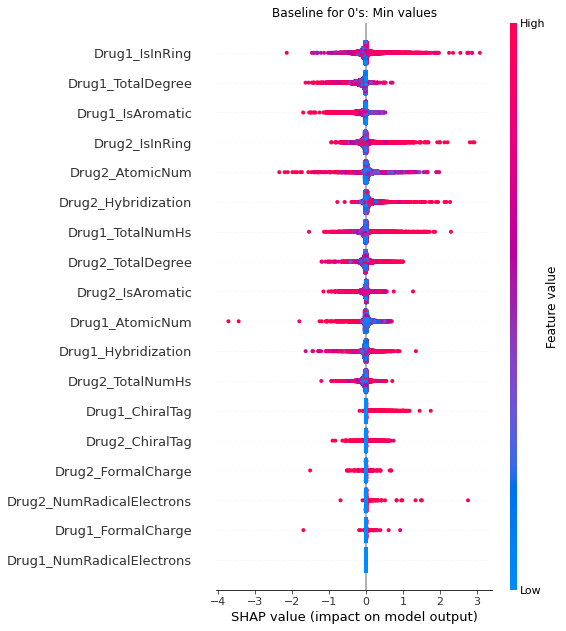

In [93]:
shap.summary_plot(concat_folds_min_zeros[:, :nr_drug_feat],
                  test_features_zeros[:, :nr_drug_feat],
                  feature_names=all_feat[:nr_drug_feat],
                  max_display=nr_drug_feat, show=False)
plt.title("Baseline for 0's: Min values")
plt.show()

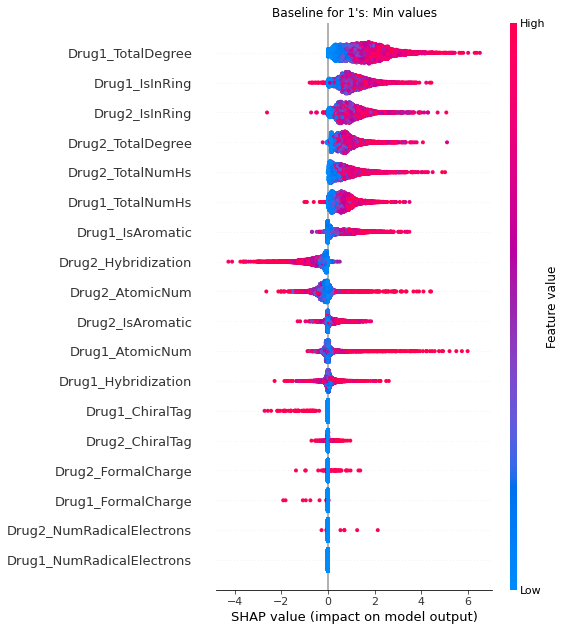

In [94]:
shap.summary_plot(concat_folds_min_ones[:, :nr_drug_feat],
                  test_features_ones[:, :nr_drug_feat],
                  feature_names=all_feat[:nr_drug_feat],
                  max_display=nr_drug_feat, show=False)
plt.title("Baseline for 1's: Min values")
plt.show()

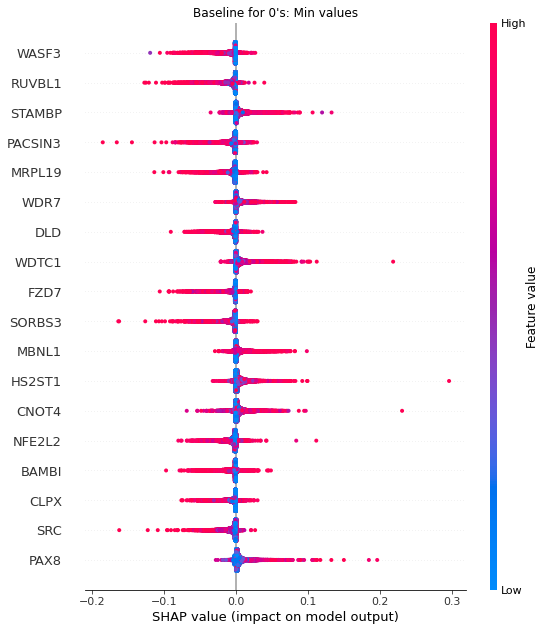

In [95]:
shap.summary_plot(concat_folds_min_zeros[:, nr_drug_feat:],
                  test_features_zeros[:, nr_drug_feat:],
                  feature_names=all_feat[nr_drug_feat:],
                  max_display=nr_drug_feat, show=False)
plt.title("Baseline for 0's: Min values")
plt.show()

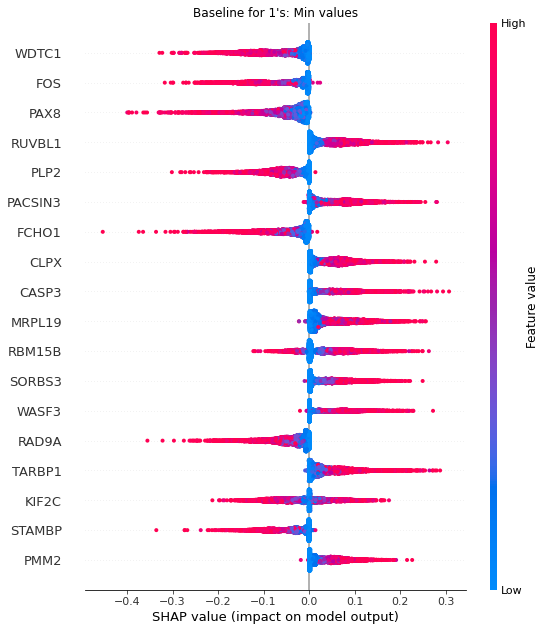

In [96]:
shap.summary_plot(concat_folds_min_ones[:, nr_drug_feat:],
                  test_features_ones[:, nr_drug_feat:],
                  feature_names=all_feat[nr_drug_feat:],
                  max_display=nr_drug_feat, show=False)
plt.title("Baseline for 1's: Min values")
plt.show()